# Vehicle Detection Project

## Goals/Steps


* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Histogram of Oriented Gradients (HOG)

#### 1. Read in Images

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


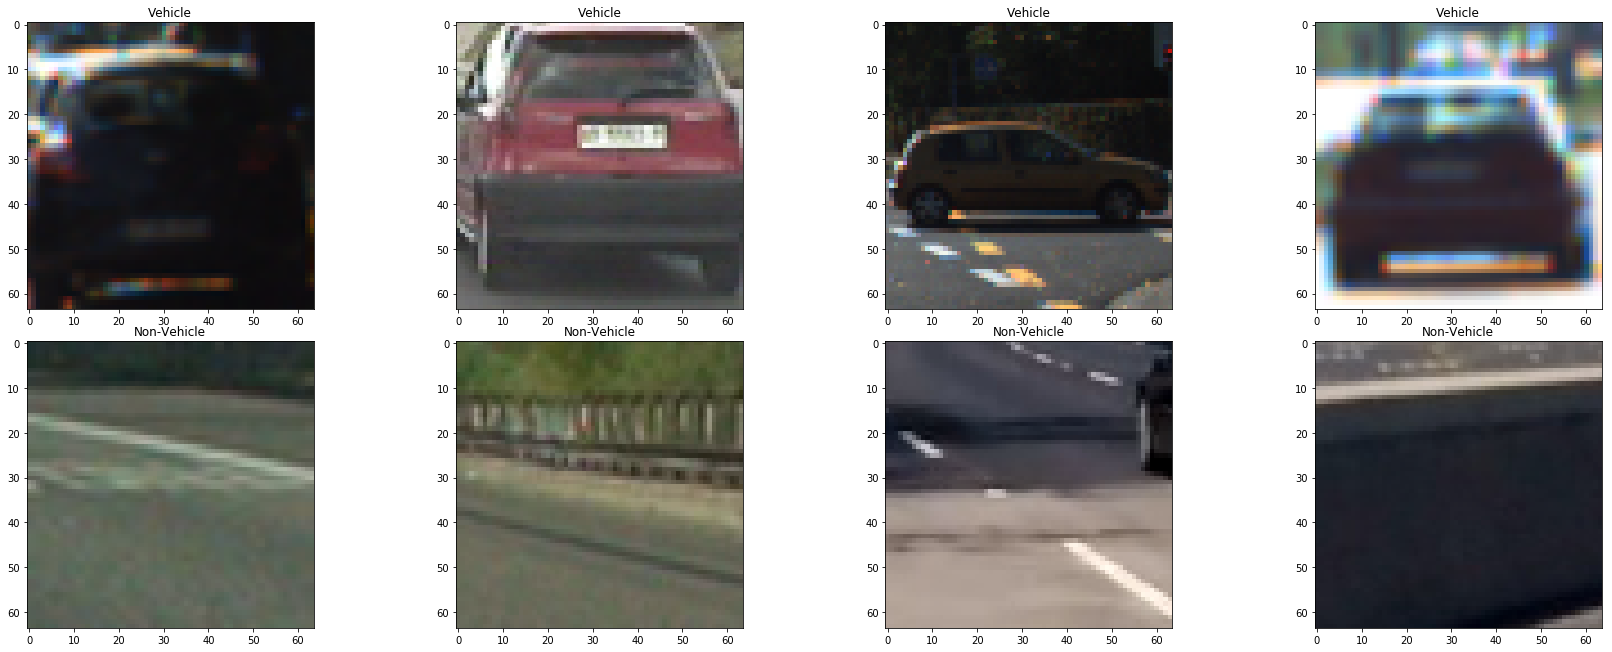

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
%matplotlib inline



if False:
    fnames = glob.glob('vehicles/**/*.png', recursive=True)
    list_vehicles = []
    for fname in fnames:
        list_vehicles.append(fname)

    fnames = glob.glob('non-vehicles/**/*.png', recursive=True)
    list_non_vehicles = []
    for fname in fnames:
        list_non_vehicles.append(fname)
    
    f, ax = plt.subplots(ncols=4, nrows=2, figsize=(24, 9))
    f.tight_layout()
    for i in range(4):
        img = cv2.cvtColor(cv2.imread(list_vehicles[i]), cv2.COLOR_BGR2RGB)
        ax[0][i].imshow(img)
        ax[0][i].set_title('Vehicle')
    
        img = cv2.cvtColor(cv2.imread(list_non_vehicles[i]), cv2.COLOR_BGR2RGB)
        ax[1][i].imshow(img)
        ax[1][i].set_title('Non-Vehicle')
    plt.show()
    
    
    
images = glob.glob('vehicles/**/*.png', recursive=True)
cars = []
notcars = []

for image in images:
        cars.append(image)
        
images = glob.glob('non-vehicles/**/*.png', recursive=True)
for image in images:
        notcars.append(image)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   





# Plot the examples
#fig = plt.figure()
#plt.subplot(121)
#plt.imshow(car_image)
#plt.title('Example Car Image')
#plt.subplot(122)
#plt.imshow(notcar_image)
#plt.title('Example Not-car Image')

if True:
    
    
    f, ax = plt.subplots(ncols=4, nrows=2, figsize=(24, 9))
    f.tight_layout()
    for i in range(4):
        car_ind = np.random.randint(0, len(cars))
        notcar_ind = np.random.randint(0, len(notcars))
    
        # Read in car / not-car images
        #car_image = mpimg.imread(cars[car_ind])
        #notcar_image = mpimg.imread(notcars[notcar_ind])

        img = cv2.cvtColor(cv2.imread(cars[car_ind]), cv2.COLOR_BGR2RGB)
        ax[0][i].imshow(img)
        ax[0][i].set_title('Vehicle')
    
        img = cv2.cvtColor(cv2.imread(notcars[notcar_ind]), cv2.COLOR_BGR2RGB)
        ax[1][i].imshow(img)
        ax[1][i].set_title('Non-Vehicle')
    plt.show()


#### HOG Filter

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
# NEED TO CHANGE bins_range if reading .png files with mpimg!
#def color_hist(img, nbins=32, bins_range=(0, 1):
def color_hist1(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


#### Example of Images color space and HOG parameters

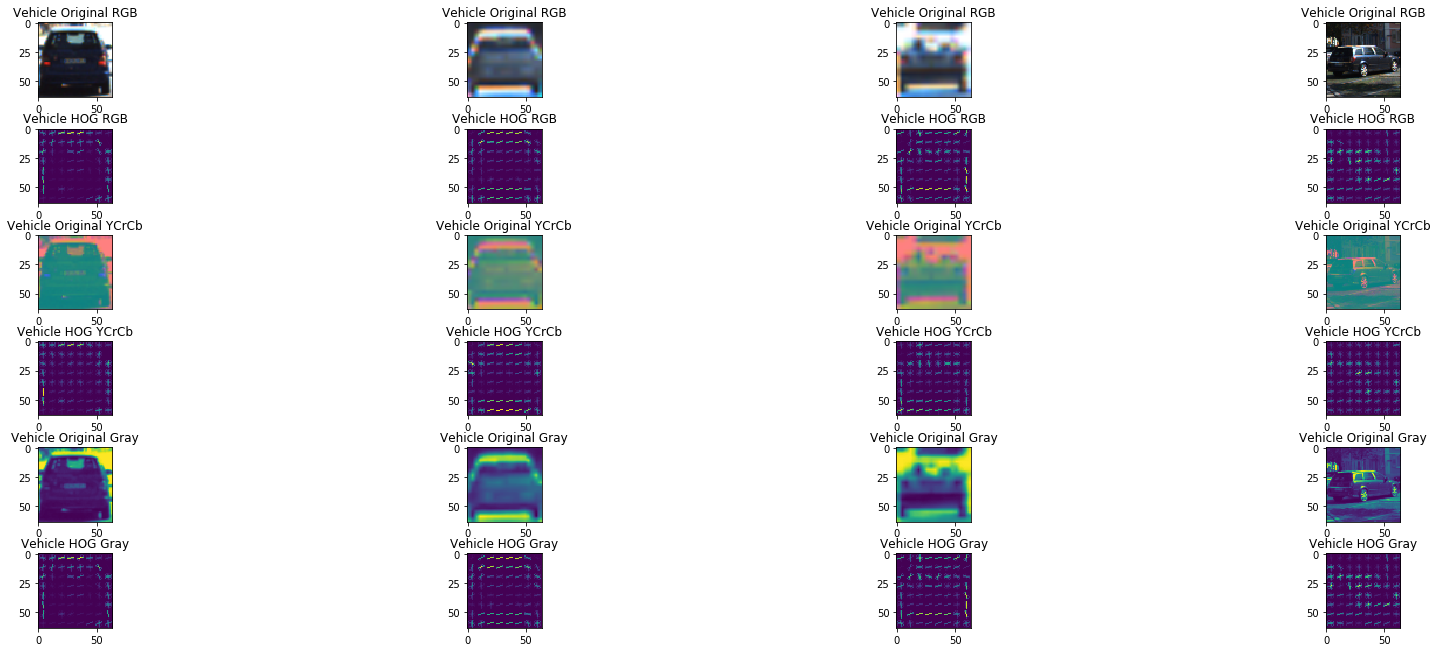

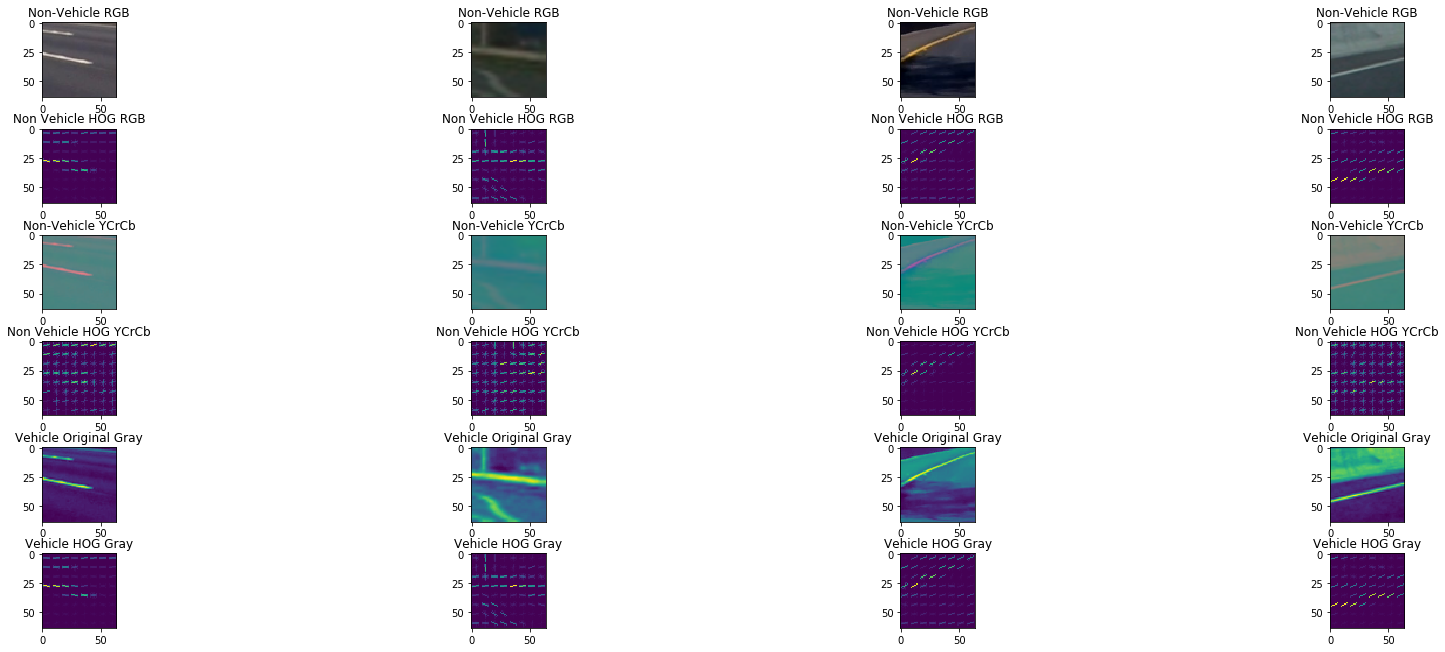

In [3]:
# Define HOG parameters
orient = 11
pix_per_cell = 8
cell_per_block = 2

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
#fig = plt.figure()
#plt.subplot(121)
#plt.imshow(image, cmap='gray')
#plt.title('Example Car Image')
#plt.subplot(122)
#plt.imshow(hog_image, cmap='gray')
#plt.title('HOG Visualization')

if True:
    
    
    f, ax = plt.subplots(ncols=4, nrows=6, figsize=(24, 9))
    f.tight_layout()
    for i in range(4):
        car_ind = np.random.randint(0, len(cars))
    
        # Read in car / not-car images
        #car_image = mpimg.imread(cars[car_ind])
        #notcar_image = mpimg.imread(notcars[notcar_ind])

        # cv2.COLOR_BGR2RGB
        
        img = cv2.cvtColor(cv2.imread(cars[car_ind]), cv2.COLOR_BGR2RGB)
        ax[0][i].imshow(img)
        ax[0][i].set_title('Vehicle Original RGB')
    
        features, hog_image = get_hog_features(img[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
        ax[1][i].imshow(hog_image)
        ax[1][i].set_title('Vehicle HOG RGB')
        
        # cv2.COLOR_RGB2YCrCb
        
        img = cv2.cvtColor(cv2.imread(cars[car_ind]), cv2.COLOR_RGB2YCrCb)
        ax[2][i].imshow(img)
        ax[2][i].set_title('Vehicle Original YCrCb')
    
        features, hog_image = get_hog_features(img[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
        ax[3][i].imshow(hog_image)
        ax[3][i].set_title('Vehicle HOG YCrCb')
        
        gray = cv2.cvtColor(cv2.imread(cars[car_ind]), cv2.COLOR_RGB2GRAY)
        ax[4][i].imshow(gray)
        ax[4][i].set_title('Vehicle Original Gray')
    
        features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
        ax[5][i].imshow(hog_image)
        ax[5][i].set_title('Vehicle HOG Gray')
        
    plt.show()
    
    f, ax = plt.subplots(ncols=4, nrows=6, figsize=(24, 9))
    f.tight_layout()
    for i in range(4):
        notcar_ind = np.random.randint(0, len(notcars))   
        
        ## Non Car RGB
        
        img = cv2.cvtColor(cv2.imread(notcars[notcar_ind]), cv2.COLOR_BGR2RGB)
        ax[0][i].imshow(img)
        ax[0][i].set_title('Non-Vehicle RGB')
        
        features, hog_image = get_hog_features(img[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
        ax[1][i].imshow(hog_image)
        ax[1][i].set_title('Non Vehicle HOG RGB')
        
        img = cv2.cvtColor(cv2.imread(notcars[notcar_ind]), cv2.COLOR_RGB2YCrCb)
        ax[2][i].imshow(img)
        ax[2][i].set_title('Non-Vehicle YCrCb')
        
        features, hog_image = get_hog_features(img[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
        ax[3][i].imshow(hog_image)
        ax[3][i].set_title('Non Vehicle HOG YCrCb')
        
        gray = cv2.cvtColor(cv2.imread(notcars[notcar_ind]), cv2.COLOR_RGB2GRAY)
        ax[4][i].imshow(gray)
        ax[4][i].set_title('Vehicle Original Gray')
    
        features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
        ax[5][i].imshow(hog_image)
        ax[5][i].set_title('Vehicle HOG Gray')
        
    plt.show()


#### Extract Features

In [4]:
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)

# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='LUV', orient=orient, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        file_features = []
        
        # Append the new feature vector to the features list
        file_features.append(hog_features)

        global spatial_size, hist_bins

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
       
    # Return list of feature vectors
    return features


#### Extract Features

In [5]:
import time

colorspace = 'YUV'
hog_channel = 'ALL'

t = time.time()
print('Starting to extract Car HOG features...')
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print('Starting to extract Non Car HOG features...')
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')



Starting to extract Car HOG features...
Starting to extract Non Car HOG features...
94.03 Seconds to extract HOG features...


#### Generate Feature Vector

In [6]:
from sklearn.model_selection import train_test_split

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9636


#### Train using SVM

In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

6.28 Seconds to train SVC...
Test Accuracy of SVC =  0.991
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
0.00157 Seconds to predict 10 labels with SVC


#### Find Features using Sliding Window

In [8]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Timing output util method
t1 = None
def time_since(comment='No comment'):
    global t1
    t2 = time.time()
    if t1 is not None:
        print(round(t2 - t1, 2), comment)
    t1 = t2

# Define a single function that can extract features using hog sub-sampling and make predictions
# def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
#               pix_per_cell, cell_per_block):
# def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
        
    # Detected bounding boxes
    bbox_detected = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    #if hog_channel == "ALL":
    #    ch1 = ctrans_tosearch[:,:,0]
    #    ch2 = ctrans_tosearch[:,:,1]
    #    ch3 = ctrans_tosearch[:,:,2]
    #else:
    #    ch1 = ctrans_tosearch[:,:,hog_channel]
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
                        
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
           
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
#             test_features = X_scaler.transform((hog_features).reshape(1, -1))
                        
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_detected.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return bbox_detected

#### Avg. Box from list of boxes

In [9]:
from numpy import mean

boxes_list = []
boxes = []
max_boxes = 3
for j in range(3):
    for i in range(8):
        box = [[i,i],[20-i,20-i]]
        if i >= max_boxes:
            boxes = boxes[1:]
        boxes.append(box)
#         print(boxes)
        avg_box = tuple(mean(boxes, axis=0))
#         print('top_left:',avg_box[0],'bottom_right:',avg_box[1])
    boxes_list.append(boxes)
    
# print(boxes_list)

flattened_boxes_list = []
for boxes in boxes_list:
    flattened_boxes_list.extend(boxes)
    
# print(flattened_boxes_list)

#### Detect False positive

In [38]:
# The VehiclesDetected class holds the bbox_detected detected by find_cars
# for the previous n video frames. These bbox_detected are combined
# and the sum is passed to the heat map detection and thresholding
# methods.
#
# This history is also used to ignore spurious false-positive bbox_detected 
# that appear only in one or two frames.
class VehiclesDetected:
    def __init__(self):
        self.max_frames = 10 # Max number of frames to keep track of
        self.frame_history = [] # Array of bbox_detected for the latest frames
    
    # For each frame, add the bbox_detected that were found. The 'bbox_detected'
    # param is the raw list of bbox_detected where bbox_detected were identified by 
    # the classifier (using the find_cars() method)
    def add_vehicles(self, bbox_detected):
        if len(self.frame_history) >= self.max_frames:
            self.frame_history = self.frame_history[1:]
        self.frame_history.append(bbox_detected)
    
    # Return a flat list of bbox_detected for the previous n frames
    def get_vehicles(self):
        bbox_detected = []
        for frame_bbox_detected in self.frame_history:
            bbox_detected.extend(frame_bbox_detected)
        return bbox_detected
    
    def get_frame_count(self):
        return len(self.frame_history)

vehiclesDetected = None

In [39]:
#### Helper function

In [40]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
        
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # Return the image
    return img

#### Create annotated image

In [54]:
def create_annotated_image(img, show_images=False):
            
    bboxes_detected_list = []
    
    for scale in scale_list:
        bboxes_detected = find_cars(img, ystart, ystop, scale, 
                          svc, X_scaler, orient, pix_per_cell, cell_per_block)
        bboxes_detected_list.extend(bboxes_detected)

    heat = np.zeros_like(img[:,:,0]).astype(np.float32)

    # Add the rects found for the current frame to the CarHistory object
    # so that it can produce a smooth rectangle for each car that is 
    # consistent from one frame to the next, and (hopefully) free of
    # spurious false-positive results.

    global vehiclesDetected
    if vehiclesDetected is not None:
        vehiclesDetected.add_vehicles(bboxes_detected_list)

        # Add heat to each box in box list
        heat = add_heat(heat, vehiclesDetected.get_vehicles())

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, vehiclesDetected.get_frame_count()//2)
    else:
        # Add heat to each box in box list
        heat = add_heat(heat, bboxes_detected_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, 1)

    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    if show_images:
        print(len(bboxes_detected_list), 'BBoxes Found')
        
        img_rects = draw_boxes(img, bboxes_detected_list)

        fig = plt.figure(figsize=(50,100))
        plt.subplot(131)
        plt.imshow(img_rects)
        plt.title('All Positions', fontsize=20)
        plt.subplot(132)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Thresholded Heat Map', fontsize=20)
        plt.subplot(133)
        plt.imshow(draw_img)
        plt.title('Thresholded Vehicle Positions', fontsize=20)
        fig.tight_layout()
        
    return draw_img


20 BBoxes Found
0 BBoxes Found
3 BBoxes Found
25 BBoxes Found
18 BBoxes Found
27 BBoxes Found


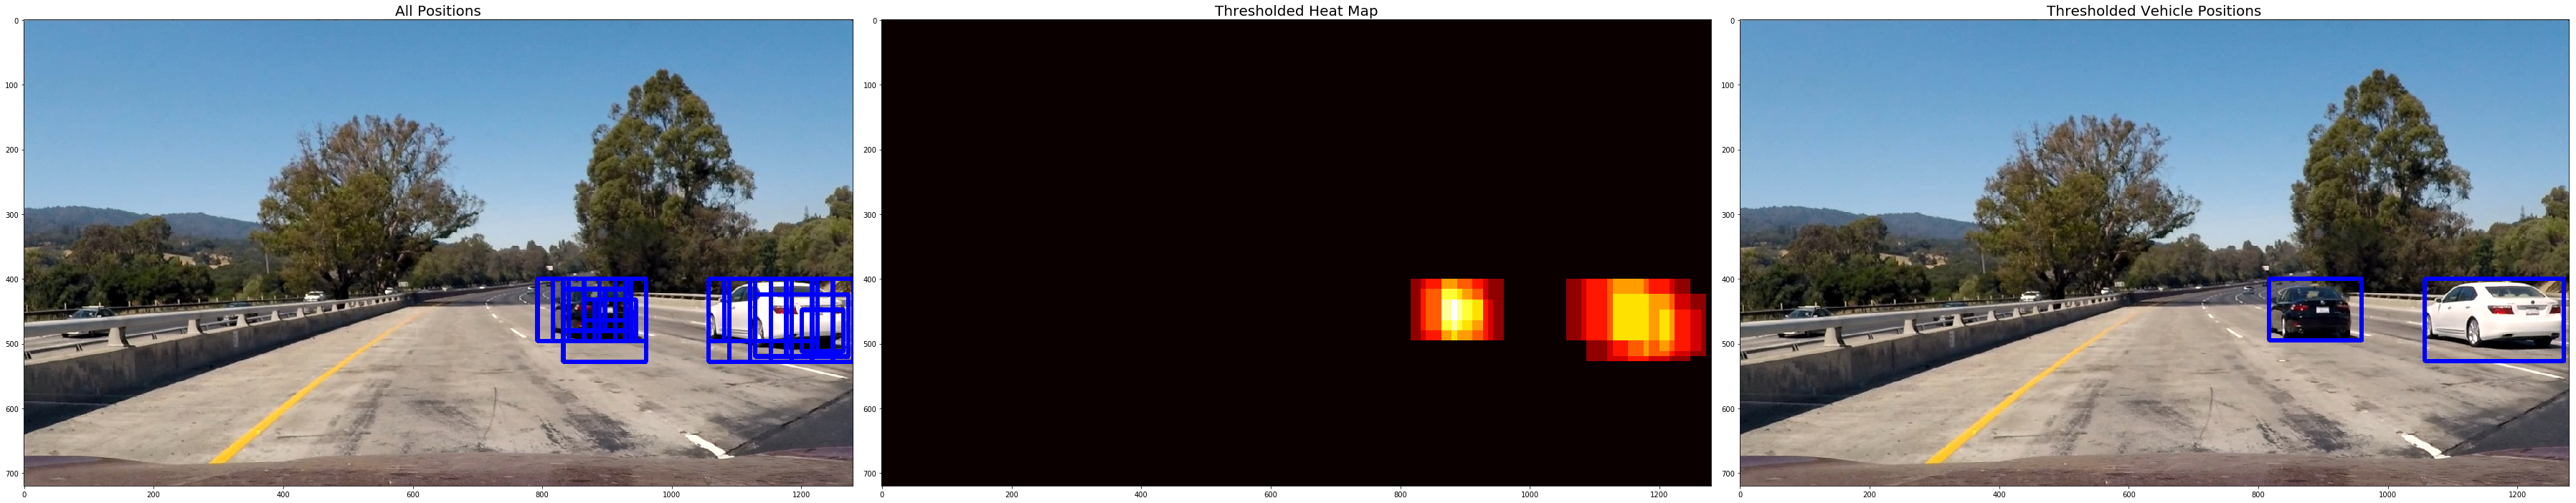

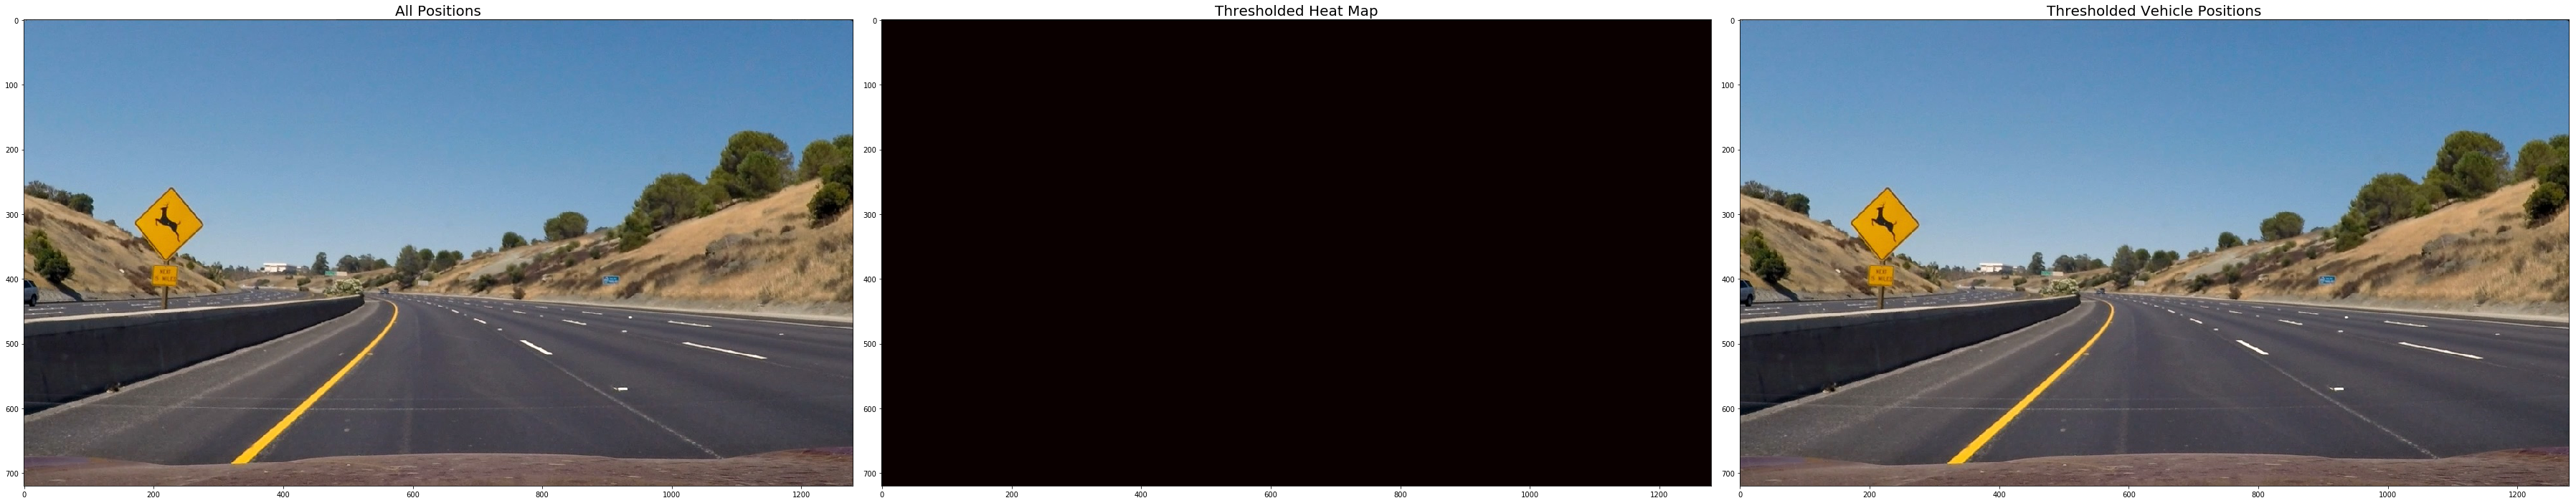

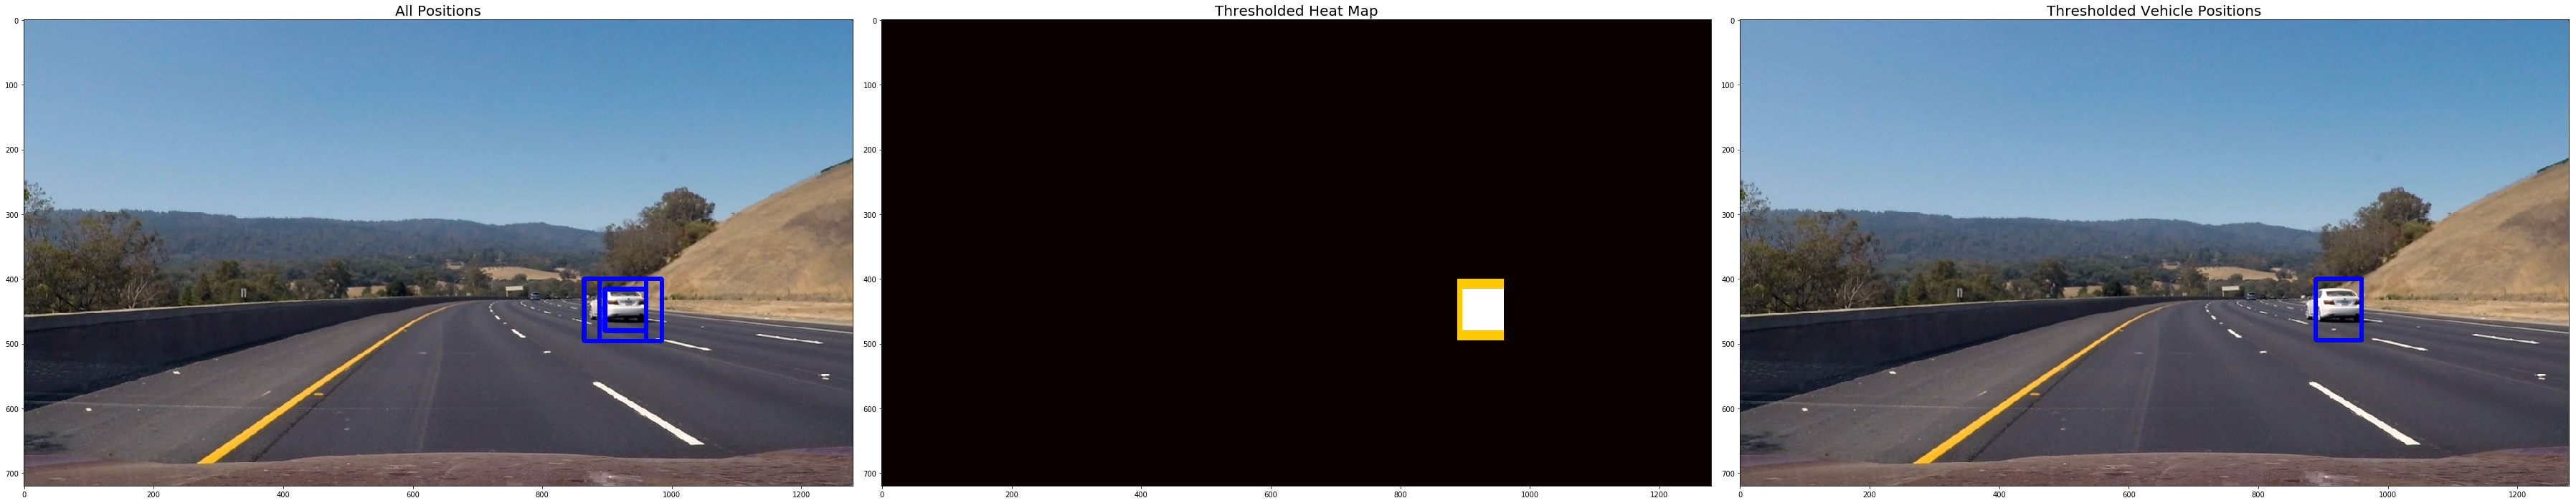

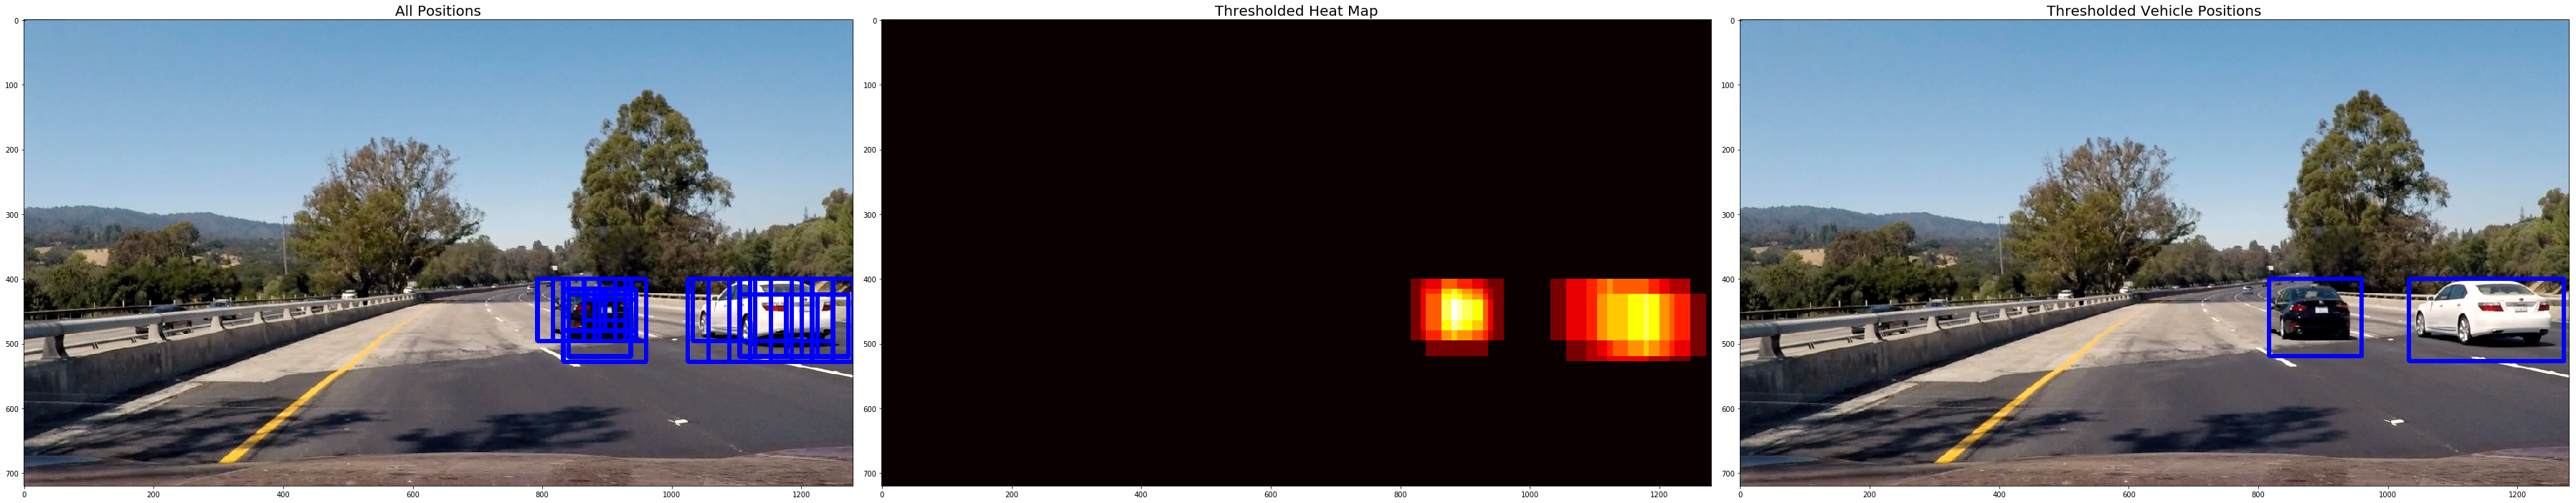

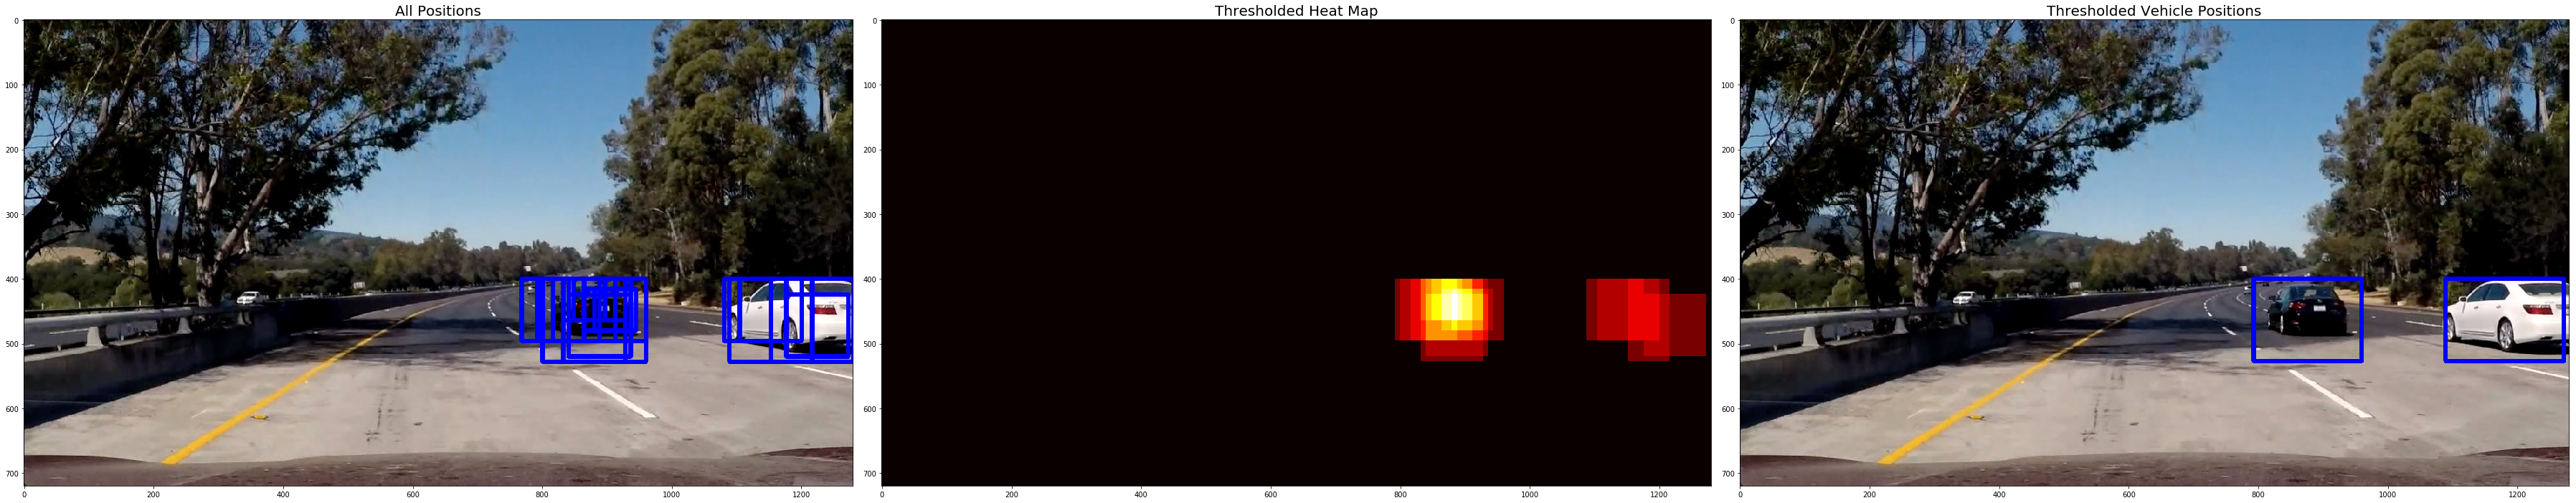

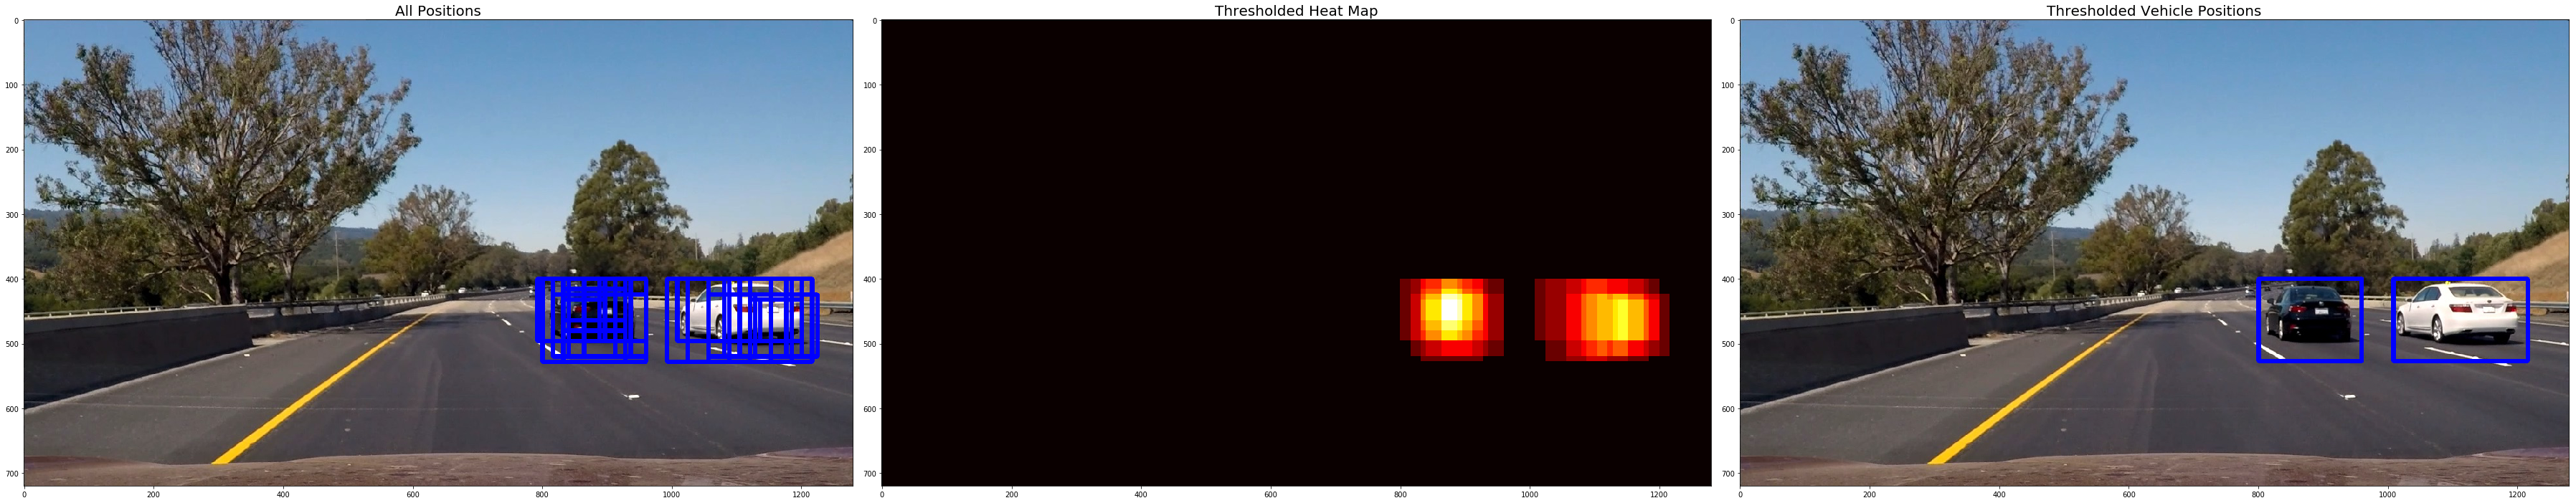

In [42]:
ystart = 400
ystop = 656
scale_list = [1, 1.5, 2, 3]



images = sorted(glob.glob('test_images/*.jpg'))
for img_name in images:
    test_img = mpimg.imread(img_name)
        
    create_annotated_image(test_img, show_images=True)

#### Process Test Video

In [43]:
def pipeline(img):
    return create_annotated_image(img, show_images=False)

output_file = 'output_images/output_test_video.mp4'
clip = VideoFileClip("test_video.mp4")

if True:
    global vehiclesDetected
    vehiclesDetected = VehiclesDetected()
    
    output_clip = clip.fl_image(pipeline)
    output_clip.ipython_display()
    %time output_clip.write_videofile(output_file, audio=False)


 97%|█████████▋| 38/39 [01:00<00:01,  1.56s/it]

[MoviePy] >>>> Building video output_images/output_test_video.mp4
[MoviePy] Writing video output_images/output_test_video.mp4



 97%|█████████▋| 38/39 [00:59<00:01,  1.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output_test_video.mp4 

CPU times: user 58.8 s, sys: 1.56 s, total: 1min
Wall time: 1min


In [44]:
    
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

#### Process Project Video

In [46]:
output_file = 'output_images/output_project_video.mp4'
clip = VideoFileClip("project_video.mp4")

if True:
    global vehiclesDetected
    vehiclesDetected = VehiclesDetected()
    
    output_clip = clip.fl_image(pipeline)
    output_clip.ipython_display()
    %time output_clip.write_videofile(output_file, audio=False)


100%|█████████▉| 1260/1261 [34:21<00:01,  1.71s/it]


[MoviePy] >>>> Building video output_images/output_project_video.mp4
[MoviePy] Writing video output_images/output_project_video.mp4


  3%|▎         | 34/1261 [00:56<33:52,  1.66s/it]

KeyboardInterrupt: 

In [ ]:
    
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))